In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

### Overview



### Part 1: Priming the data

Different datasets have certain marker values associated with certain locations at different levels (e.g., the neighbourhood level or sub-district level). These values are essential for merging datasets (for example, one dataset may contain a neighbourhood's number of cars, and another a tree and which neighbourhood it is in)

Not every dataset uses the same marker values, and these marker values can have different column names, so I first need to standardise it all. I'm also making some functions that will streamline the data cleaning process a bit.

In [131]:
# functions for data cleaning
# return the proportion of nan each column in the data
def na_proportion(series: pd.Series):
    return series.isna().sum() / len(series)

# returns a dataframe without the columns that have higher proportion of na 
# than threshold. The reason I'm doing this is because drop.na could remove
# very large amounts of data just due to one a column being mostly nans. So
# columns full of nans get removed. 
# default threshold: 40% of nan means removal
def stripped_threshold_na_columns(df: pd.DataFrame, threshold = 0.4):
    df_return = pd.DataFrame()
    for column in df.columns:
        if na_proportion(df[column]) < threshold:
            df_return[column] = df[column]
    return df_return

# if a value occurs less than n times in a series, replace it with placeholder
def replace_less_than_n_values(series: pd.Series, n = 10, placeholder = np.nan):
    value_counts = series.value_counts()
    values_to_replace = value_counts[value_counts < n].index
    return series.replace(to_replace=values_to_replace, value=placeholder)

# returns the n most common values in a series (by default the 10 most common)
def most_common_n_values(series: pd.Series, n = 10):
    return series.value_counts()[:n].index.tolist()


# return a series with its least common values converted to a different value
# nans are also replaceable
# by default, the string 'other'
def otherise(value, most_common_values, other, nan_replace):
    if value in most_common_values:
        return value
    if value is np.nan:
        return nan_replace
    return other

def otherise_less_common_values(
        series: pd.Series, 
        most_common_values, 
        other='other', 
        nan_replace = np.nan
    ):
    return series.apply(
        lambda value: otherise(value, most_common_values, other, nan_replace)
    )


In [132]:
# tree data
df_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
# amsterdam neighbourhood meta data, i.e. matching neighbourhood name with ID
df_buurt_meta = pd.read_csv('data/gebieden-buurten-2024-03-12T12 09 07.653588.csv')
# amsterdam sub-district meta data, to match each neighbourhood with its district
df_wijk_meta = pd.read_csv('data/gebieden_wijken.csv')

In [133]:
# standardise names of neighbourhood id column so we can merge on that column
buurt_id_column = 'buurt_id'
wijk_id_column = 'wijk_id'

# rename buurt id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Identificatie': buurt_id_column}
)
df_trees = df_trees.rename(
    columns={'Gbdbuurtid': buurt_id_column}
)

# rename wijk id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Ligtinwijkid': wijk_id_column}
)
df_wijk_meta = df_wijk_meta.rename(
    columns={'Identificatie': wijk_id_column}
)


In [134]:
# match each buurt (neighbourhood) with its associated wijk (sub-district)
df_buurt_simple = df_buurt_meta[[
    buurt_id_column, wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_buurt_simple = df_buurt_simple.rename(
    columns={
        'Naam': 'Naam_buurt',
        'Code': 'Code_buurt',
        'Cbscode': 'Cbscode_buurt',
        'Geometrie': 'Geometrie_buurt'
    }
)

df_wijk_simple = df_wijk_meta[[
    wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_wijk_simple = df_wijk_simple.rename(
    columns={
        'Naam': 'Naam_wijk',
        'Code': 'Code_wijk',
        'Cbscode': 'Cbscode_wijk',
        'Geometrie': 'Geometrie_wijk'
    }
)

df_location_data = pd.merge(df_buurt_simple, df_wijk_simple, on=wijk_id_column)

Now we can merge datasets based on shared location markers. Yay!

### Part 2: Tree data

I am making a dataset which contains a list of trees from Amsterdam's tree census and some information associated with each tree. This is the cleaning up of that data.

#### Removing columns with too many nans, then removing nans
To prevent removing too much data, I'm discarding columns that have too many nans (the diameter column for example), making exceptions only for interesting data.

Then I remove any row with a nan value for the model.

It's possible that I'm skewing the data in a way that will affect my model (example: maybe there is a specific relationship between height and species that's only found in trees that also have a nan value somewhere) but I don't have time to look at that and it's probably beyond the requirements of the assignment.

In [135]:
# clean up tree data
# removing nans
# we want to remove columns that have too many nans so that we don't reduce
# the entire dataset too much by using .dropna
# I will make an exception for Standplaatsgedetailleerd (middle in which tree
# is grown) since that seems like an interesting statistic
print(f'nan proportion Standplaatsgedetailleerd {na_proportion(df_trees['Standplaatsgedetailleerd'])}')
# this will remove 62% of the data, out of 280000 so we will be totally fine
growth_ground = df_trees['Standplaatsgedetailleerd']

print(f'shape before dropna: {df_trees.shape}')

df_trees = stripped_threshold_na_columns(df_trees)
df_trees['growth_ground'] = growth_ground
df_trees.dropna(inplace=True)

print(f'shape after dropna: {df_trees.shape}')


nan proportion Standplaatsgedetailleerd 0.620510336029891
shape before dropna: (286909, 14)
shape after dropna: (98285, 13)


In [136]:
# height
# we only have approximate measures for tree height :(
# Brute force normalising it to numbers to avoid using regex and preserve my sanity
# There are some limitations from applying a linear regression model
# to height that is calculated this way.
def extract_height_data(data):
    if data == 'a. tot 6 m.':
        return 3
    if data == 'b. 6 tot 9 m.':
        return 7.5
    if data == 'c. 9 tot 12 m.':
        return 10.5
    if data == 'd. 12 tot 15 m.':
        return 13.5
    if data == 'e. 15 tot 18 m.':
        return 16.5
    if data == 'f. 18 tot 24 m.':
        return 21
    if data == 'g. 24 m. en hoger':
        return 24
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_fixed'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data(x)
)

df_trees.dropna(inplace=True)




In [137]:
import random
def extract_height_data_randomised(data):
    if data == 'a. tot 6 m.':
        return random.uniform(0, 6)
    if data == 'b. 6 tot 9 m.':
        return random.uniform(6, 9)
    if data == 'c. 9 tot 12 m.':
        return random.uniform(9, 12)
    if data == 'd. 12 tot 15 m.':
        return random.uniform(12, 15)
    if data == 'e. 15 tot 18 m.':
        return random.uniform(15, 18)
    if data == 'f. 18 tot 24 m.':
        return random.uniform(18, 24)
    if data == 'g. 24 m. en hoger':
        return random.uniform(24, 30)
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_random'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data_randomised(x)
)

Text(0, 0.5, 'Frequency')

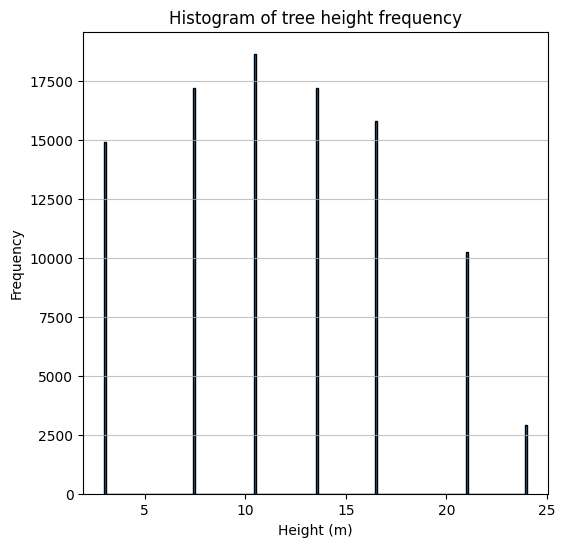

In [138]:
plt.figure(figsize=(6, 6))
plt.hist(df_trees['tree_height_fixed'], bins=200, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of tree height frequency")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")# visualise tree height distribution



In [139]:
# neighbourhood that tree is in (ID)
print(df_trees['buurt_id'].value_counts())

buurt_id
3.630980e+12    2617
3.630980e+12    1912
3.630980e+12    1562
3.630980e+12    1193
3.630980e+12    1188
                ... 
3.630980e+12       3
3.630980e+12       2
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
Name: count, Length: 494, dtype: int64


In [140]:
# tree administrator ('Typebeheerderplus')
# categorical
print(df_trees['Typebeheerderplus'].value_counts())
admin_threshold = 15
df_trees['tree_admin'] = replace_less_than_n_values(
    df_trees['Typebeheerderplus'],
    admin_threshold
)
print(f'proportion of nan for admin after removal: {na_proportion(df_trees['Typebeheerderplus'])}')

df_trees.dropna(inplace=True)

Typebeheerderplus
R&E_VOR_Bomen                     94378
Recreatieschap Noord-Holland       1386
Gemeente Amsterdam, rve Sport       444
RVE Spieringhorn Sportpark          342
R&E_VOR_Groen                        84
Amsterdamse Bos                      63
Rijkswaterstaat                      49
Gemeentelijk Vastgoed                35
Amsterdamse bos - eigen dienst       34
RVE Spieringpark                     23
Stichting                             8
Havenbedrijf                          6
Volkstuinpark                         3
Begraafplaats Ransdorp                3
Woningcorporatie                      2
Begraafplaats Nieuwendam              2
Natuurlijk persoon                    2
Schooltuinen                          1
Westpoort                             1
SOC_S&B_Sport                         1
Name: count, dtype: int64
proportion of nan for admin after removal: 0.0


In [141]:
print(df_trees['tree_admin'].value_counts())

tree_admin
R&E_VOR_Bomen                     94378
Recreatieschap Noord-Holland       1386
Gemeente Amsterdam, rve Sport       444
RVE Spieringhorn Sportpark          342
R&E_VOR_Groen                        84
Amsterdamse Bos                      63
Rijkswaterstaat                      49
Gemeentelijk Vastgoed                35
Amsterdamse bos - eigen dienst       34
RVE Spieringpark                     23
Name: count, dtype: int64


In [142]:
# municipality that owns the trees
print(df_trees['Typeeigenaarplus'].value_counts())
# the overwhelming majority of trees are owned by amsterdam.
# let's have values for just "amsterdam" and "not amsterdam"
amsterdam_ownership = ['Gemeente Amsterdam']
df_trees['tree_municipality'] = otherise_less_common_values(
    df_trees['Typeeigenaarplus'], amsterdam_ownership
)

Typeeigenaarplus
Gemeente Amsterdam       94254
Gemeente Weesp            2337
Gemeentelijk Vastgoed      232
Gemeente Diemen              8
Gemeente Ouder-Amstel        7
Name: count, dtype: int64


In [143]:
df_trees['tree_municipality'].value_counts()

tree_municipality
Gemeente Amsterdam    94254
other                  2584
Name: count, dtype: int64

In [144]:
# tree planting year
print(
    f'proportion of nan for planting year: {na_proportion(df_trees['Jaarvanaanleg'])}'
)
# not many nans :)
print(df_trees['Jaarvanaanleg'].value_counts())
# lots of zeros :(
# Removing all the rows with nonsensical years
year_threshold = 1500 # let's admit really old trees because they are awesome
df_trees = df_trees[df_trees.Jaarvanaanleg > year_threshold]
df_trees.rename(columns={
    'Jaarvanaanleg': 'year_planted'
}, inplace=True)


proportion of nan for planting year: 0.0
Jaarvanaanleg
1990.0    6338
0.0       5914
1970.0    5530
1980.0    4918
1985.0    4763
          ... 
1921.0       1
1890.0       1
200.0        1
20.0         1
1881.0       1
Name: count, Length: 131, dtype: int64


In [145]:
df_trees['age'] = 2024 - df_trees['year_planted']

<Axes: xlabel='age', ylabel='Count'>

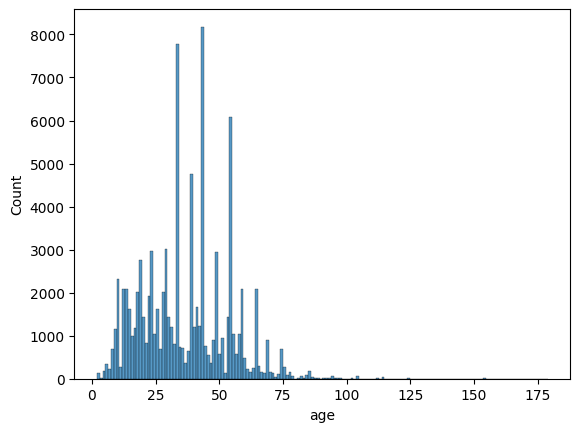

In [146]:
sns.histplot(df_trees['age'])

In [147]:
# there are three columns for the species of the tree
# Soortnaam: specific latin name species
print(df_trees['Soortnaam'].value_counts())
# Sortnaamkort/Sortnaamtop are for grouped species (they're the same)
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
print(df_trees['Soortnaamkort'].value_counts())
print(f'nan proportion Soortnaamtop: {na_proportion(df_trees['Soortnaamtop'])}')
print(df_trees['Soortnaamtop'].value_counts())

# let's choose both, even if they will by definition be highly correlated in some ways

Soortnaam
Platanus hispanica               5463
Fraxinus excelsior               3001
Quercus robur                    2669
Acer campestre                   2578
Salix alba                       2483
                                 ... 
Acer negundo 'Flamingo'             1
Acer pseudoplatanus 'Wilhelm'       1
Prunus serrulata 'Asano'            1
Picea                               1
Fagus sylvatica 'Rohanii'           1
Name: count, Length: 911, dtype: int64
nan proportion Soortnaamkort: 0.0
Soortnaamkort
Tilia          10268
Ulmus          10243
Acer            9097
Fraxinus        7349
Platanus        5758
               ...  
Platycladus        1
Sciadopitys        1
Diospyros          1
Viburnum           1
Cupressus          1
Name: count, Length: 105, dtype: int64
nan proportion Soortnaamtop: 0.0
Soortnaamtop
Linde (Tilia)         10268
Iep (Ulmus)           10243
Esdoorn (Acer)         9097
Es (Fraxinus)          7349
Plataan (Platanus)     5758
                      ...  
S

In [148]:
# Soortnaam (exact species)
# How many species are there?
print(f'number of species: {df_trees['Soortnaam'].value_counts().shape}')
# let's remove trees which species there are too few of
species_threshold = 10
df_trees['species'] = replace_less_than_n_values(
    df_trees['Soortnaam'],
    species_threshold
)
# how much did that remove?
print(f'number of species after removal: {df_trees['species'].value_counts().shape}')
print(f'nan proportion Soortnaam after removal: {na_proportion(df_trees['species'])}')
df_trees.dropna(inplace=True)

number of species: (911,)
number of species after removal: (413,)
nan proportion Soortnaam after removal: 0.017168939727232733


In [149]:
# Soortnaamkort (species group)
# How many groups are there?
print(f'number of species groups: {df_trees['Soortnaamkort'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
# let's remove trees which species group there are too few of
gr_species_threshold = 10
df_trees['species_group'] = replace_less_than_n_values(
    df_trees['Soortnaamkort'],
    gr_species_threshold
)
# how much did that remove?
print(f'number of species groups after removal: {df_trees['species_group'].value_counts().shape}')
print(f'nan proportion species_group after removal: {na_proportion(df_trees['species_group'])}')
df_trees.dropna(inplace=True)


number of species groups: (65,)
nan proportion Soortnaamkort: 0.0
number of species groups after removal: (65,)
nan proportion species_group after removal: 0.0


In [150]:
# Typeobject (status of the object)
print(f'{df_trees['Typeobject'].value_counts()}')
# seems fine already. will just nan up the one boomstam_algemeen
df_trees['tree_treatment'] = replace_less_than_n_values(df_trees['Typeobject'])
df_trees.dropna(inplace=True)

Typeobject
Boom niet vrij uitgroeiend    75000
Boom vrij uitgroeiend          7805
Knotboom                       2545
Vormboom                       1688
Gekandelaberde boom            1482
Stobbe                          708
Leiboom                         121
Fruitboom                        10
Name: count, dtype: int64


In [151]:
# Typesoortnaam (the sort of thing that this is)
print(df_trees['Typesoortnaam'].value_counts())
# we are only interested in trees
only_trees = most_common_n_values(df_trees['Typesoortnaam'], n = 1)
df_trees['plant_type'] = otherise_less_common_values(
    df_trees['Typesoortnaam'],
    only_trees,
    other = np.nan
)
df_trees.dropna(inplace=True)

Typesoortnaam
Bomen       89341
Heesters       16
Algemeen        2
Name: count, dtype: int64


In [152]:
# number of trees left
print(df_trees.shape)

(89341, 22)


In [153]:
df_with_location = pd.merge(df_trees, df_location_data, on=buurt_id_column)
display(df_with_location.sample(10).head())
print(df_with_location.columns)

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,plant_type,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk
65953,1109253,3.630980e+12,SRID=28992;POINT (120930.15 492111.52),R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,1995.0,Carpinus betulus 'Fastigiata',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000086,Circus/Kermisbuurt,NA06,BU0363NA06,"SRID=28992;POLYGON ((120793.102 492708.141, 12...",Oostzanerwerf,NaN,WK0363NA,"SRID=28992;POLYGON((121495.876 493158.163,1214..."
88843,2065952,3.630980e+12,SRID=28992;POINT (117102.832326197 488400.8596...,R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2015.0,Betula ermanii,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000043,Meerwaldtbuurt,FD03,BU0363FD03,"SRID=28992;POLYGON ((117677.336 488379.435, 11...",Slotermeer-Noordoost,FD,WK0363FD,"SRID=28992;POLYGON((117677.336 488379.435,1176..."
85239,1170115,3.630980e+12,SRID=28992;POINT (129077.526520031 484427.7010...,R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2018.0,Ulmus 'Homestead',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000081,Theo van Goghparkbuurt,ML02,BU0363ML02,"SRID=28992;POLYGON ((129298.966 485048.564, 12...",IJburg-Zuid,ML,WK0363ML,"SRID=28992;POLYGON((129298.966 485048.564,1292..."
49411,1064290,3.630980e+12,SRID=28992;POINT (124810.23 489243.51),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,1996.0,Malus baccata 'Street Parade',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000098,Tuindorp Nieuwendam-Oost,NN02,BU0363NN02,"SRID=28992;POLYGON ((125369.851 489295.366, 12...",Tuindorp Nieuwendam,NN,WK0363NN,"SRID=28992;POLYGON((125369.851 489295.366,1253..."
61157,1096417,3.630980e+12,SRID=28992;POINT (114310.43 486186.59),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1995.0,Platanus hispanica,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000048,Reimerswaal,FJ01,BU0363FJ01,"SRID=28992;POLYGON ((114685.179 486448.198, 11...",Osdorp-Midden,FJ,WK0363FJ,"SRID=28992;POLYGON((114947.26 485733.106,11487..."


Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk'],
      dtype='object')


In [154]:
# parking data
df_parking = pd.read_csv('data/parking_data_amsterdam.csv')


In [155]:
# some info about this dataset
print(f'shape of parking dataset: {df_parking.shape}')
print(f'columns: {df_parking.columns}')
parking_count_per_buurt = df_parking['buurtcode'].value_counts()
parking_per_neighbourhood = pd.DataFrame({
    'Code_buurt': parking_count_per_buurt.index,
    'parked_cars_in_neighbourhood': parking_count_per_buurt.values
})
print(parking_per_neighbourhood)


shape of parking dataset: (266622, 9)
columns: Index(['WKT', 'id', 'buurtcode', 'straatnaam', 'type', 'soort', 'e_type',
       'aantal', 'versiedatum'],
      dtype='object')
    Code_buurt  parked_cars_in_neighbourhood
0         KQ05                          2986
1         KR03                          2385
2         FH02                          2373
3         FA03                          2348
4         MN03                          2231
..         ...                           ...
497       AD08                             7
498       TA05                             6
499       NQ07                             4
500       FN03                             4
501       MP02                             2

[502 rows x 2 columns]


In [156]:
df_with_parking = pd.merge(
    df_with_location, 
    parking_per_neighbourhood,
    on='Code_buurt'
)
df_with_parking.dropna(inplace=True)
display(df_with_parking.sample(10).head())

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,parked_cars_in_neighbourhood
9613,952168,3.630980e+12,SRID=28992;POINT (118674.7 483002.59),R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1973.0,Alnus glutinosa,Boom vrij uitgroeiend,Bomen,...,3630970000069,Amsterdamse Bos,KQ01,BU0363KQ01,"SRID=28992;POLYGON ((117719.023 482536.594, 11...",Buitenveldert-West,KQ,WK0363KQ,"SRID=28992;POLYGON((120391.206 482920.349,1203...",169
11399,956615,3.630980e+12,SRID=28992;POINT (122214.01 484573.13),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1990.0,Gleditsia triacanthos,Boom niet vrij uitgroeiend,Bomen,...,3630970000065,IJselbuurt-Oost,KL02,BU0363KL02,"SRID=28992;POLYGON ((122557.978 484786.63, 122...",IJselbuurt,KL,WK0363KL,"SRID=28992;POLYGON((122636.213 484573.096,1225...",766
59206,1097166,3.630980e+12,SRID=28992;POINT (115866.536180093 487171.0015...,R&E_VOR_Bomen,f. 18 tot 24 m.,Gemeente Amsterdam,1965.0,Tilia europaea,Boom niet vrij uitgroeiend,Bomen,...,3630970000044,Sloterpark,FE04,BU0363FE04,"SRID=28992;POLYGON ((116756.514 487148.113, 11...",Slotermeer-Zuidoost,FE,WK0363FE,"SRID=28992;POLYGON((116756.514 487148.113,1168...",56
16437,971806,3.630980e+12,SRID=28992;POINT (127025.93 480868.63),R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,2007.0,Cedrus deodara,Boom niet vrij uitgroeiend,Bomen,...,3630970000112,De Kameleon e.o.,TG03,BU0363TG03,"SRID=28992;POLYGON ((127640.202 481122.04, 127...",Bijlmermuseum,TG,WK0363TG,"SRID=28992;POLYGON((127640.202 481122.04,12762...",463
7729,946666,3.630980e+12,SRID=28992;POINT (121490.46 482705.21),R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1970.0,Pinus nigra,Boom vrij uitgroeiend,Bomen,...,3630970000070,Amstelpark,KR04,BU0363KR04,"SRID=28992;POLYGON ((121706.41 482874.35, 1216...",Buitenveldert-Oost,KR,WK0363KR,"SRID=28992;POLYGON((121706.41 482874.35,121615...",414


Text(0, 0.5, 'Frequency')

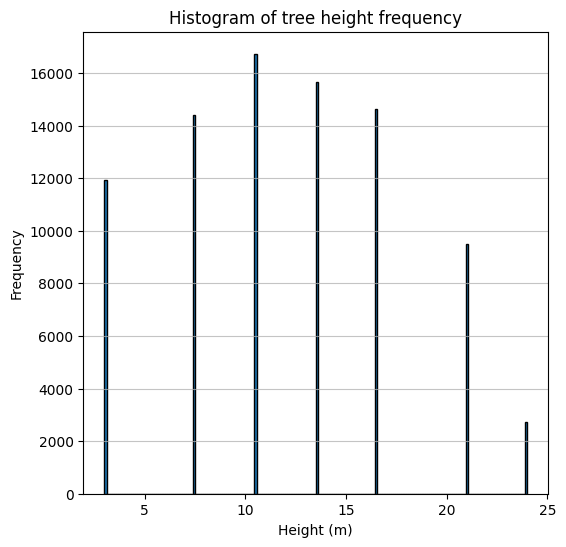

In [157]:
# let's plot the height of trees of the cleaned up dataset
plt.figure(figsize=(6, 6))
plt.hist(df_with_parking['tree_height_fixed'], bins=200, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of tree height frequency")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")

In [158]:
# last cleaning steps to make dataset smaller
df_with_parking.columns

Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')

In [159]:
# removing redundant columns
columns_to_drop = ['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus', 
                   'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
                    'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
                    'Soortnaamtop', 'wijk_id', 'Code_buurt', 'Cbscode_buurt',
                    'Geometrie_buurt', 'Code_wijk', 'Cbscode_wijk',
                    'Geometrie_wijk', 'plant_type'
]
df_trees_final = df_with_parking.drop(columns=columns_to_drop)

In [160]:
df_trees_final.to_csv('data/clean_tree_data.csv')